In [1]:
# paste install script here
import os
os.environ['PATH'] += ':/home/oslab/Luminescent/bin'

running luminescent python frontend
2025-05-31 22:15:06.928 | WARNING  | kfactory.kcell:show:3516 - Could not connect to klive server


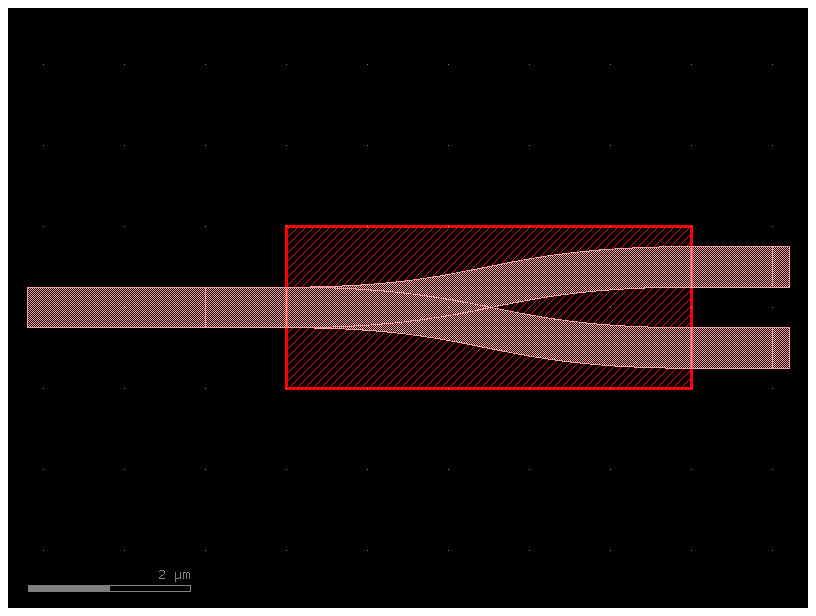

In [2]:
"""
We inverse design a 1x2 wavelength demultiplexer separating 1150m and 1850um signals each with 100nm bandwidth. Done in 2.5D for sake of demonstration with limited RAM.

"""

import os
import numpy as np
import luminescent as lumi
from luminescent import DESIGN, WG, CLAD
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack

path = os.path.join("runs", "demux")
length = 5.0
width = 2.0
width_wg = 0.5

# margins
source_port_margin = 2
margin = 0.2
xmargin_mode = 0.5

# makes gdsfadory component to be optimized. has rectangular design region with port stubs. ports numbered clockwise from bottom left. `io` specifies input output paths for initial geometry
c = gf.Component()
dut = c << lumi.mimo(
    length,
    width,
    west=1,
    east=2,
    width_wg=width_wg,
    io=[(1, 2), (1, 3)],
    layer=WG,
    design_layer=DESIGN,
)

# margin extensions
ext1 = c << gf.components.straight(margin + source_port_margin, width=width_wg)
ext2 = c << gf.components.straight(margin, width=width_wg)
ext3 = c << gf.components.straight(margin, width=width_wg)
ext1.connect("o2", dut.ports["o1"])
ext2.connect("o1", dut.ports["o2"])
ext3.connect("o1", dut.ports["o3"])

# add ports
c.add_port("o1", port=dut.ports["o1"])
c.add_port("o2", port=dut.ports["o2"])
c.add_port("o3", port=dut.ports["o3"])
c << gf.components.bbox(component=c, layer=CLAD, top=1, bottom=1)

c.plot()
c.show()


xmargin_mode: [0.5, 0.5]
using simulation folder runs/demux
loading problem from /home/oslab/Luminescent.jl/runs/demux

running Luminescent julia backend
λ = F(center_wavelength) = 1.5f0
setting up simulation...
meshing geometry - can take few minutes...
32.570817 seconds (10.13 M allocations: 11.494 GiB, 9.21% gc time, 29.70% compilation time)
making sources...
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
making monitors...
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d


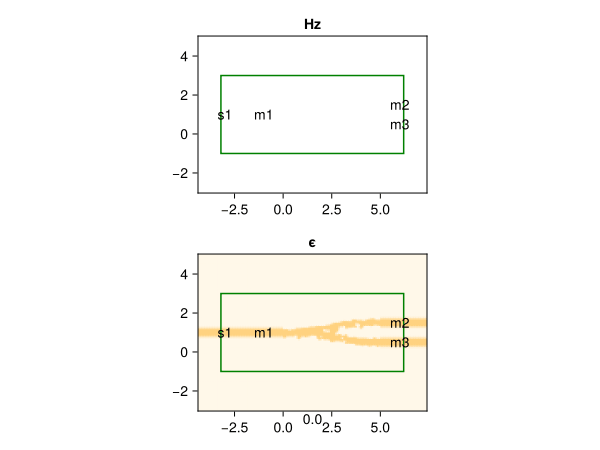

In [ ]:
# layer stack. lower mesh order layers override higher mesh order layers. for 2.5D problems as is here, the mesher will slice thru middle of 'core' layer
thickness = 0.22
materials = lumi.MATERIALS
layer_stack = LayerStack(
    layers={
        "design": LayerLevel(
            layer=LogicalLayer(layer=DESIGN),
            thickness=thickness,
            zmin=0.0,
            material="design",
            mesh_order=0,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=thickness,
            zmin=0.0,
            material="Si",
            mesh_order=1,
        ),
        "clad": LayerLevel(
            layer=LogicalLayer(layer=CLAD),
            thickness=10,
            zmin=-5,
            material="SiO2",
            mesh_order=2,
        ),
    }
)

# optimization targets of T params. o1@0 means optical port 1 on mode 0 (fundamental mode)
# each wavelength group gets its own mode
wavelength_groups = [np.linspace(1.1, 1.2, 3), np.linspace(1.8, 1.9, 3)]
weight = 1 / sum(map(len, wavelength_groups))
targets = [
    lumi.Target("o2@0,o1@0", 1.0, weight=weight, wavelength=wl)
    for wl in wavelength_groups[0]
] + [
    lumi.Target("o3@0,o1@0", 1.0, weight=weight, wavelength=wl)
    for wl in wavelength_groups[1]
]

lumi.make_prob(
    path,  # path to make problem folder
    c,
    wavelengths=wavelength_groups,
    #
    source_port_margin=source_port_margin,
    xmargin_mode=xmargin_mode,
    #
    nres=5,  # number of grid points per wavelength in material (not vacuum)
    #
    materials=lumi.MATERIALS,
    layer_stack=layer_stack,
    approx_2D_mode="TE",  # makes problem 2.5D instead of 3D
    #
    targets=targets,
    lmin=0.2,  # approximate minimum feature size
    fill_material="Si",
    void_material="SiO2",
    init_holes=True,
    stoploss=0.05,
    iters=80,  # max iters
    #
    saveat=1,  # save frame every `saveat` periods for movie
    force=True,  # delete and overwrite existing path
)

# runs adjoint optimization.
lumi.solve(path)
lumi.make_movie(path)

# if `path` has `solution.json` from previous run, `solve` will use it as initial geometry for finetuning.
# lumi.solve(path, iters=50, stoploss=.03)
# sol = lumi.load_sol(path)
